In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img

#Icrease the scale for a larger diffraction pattern. Increase the resolution for a larger sized image. Default is scale = 5, 
#resolution = 250
scale = 6
resolution = 250

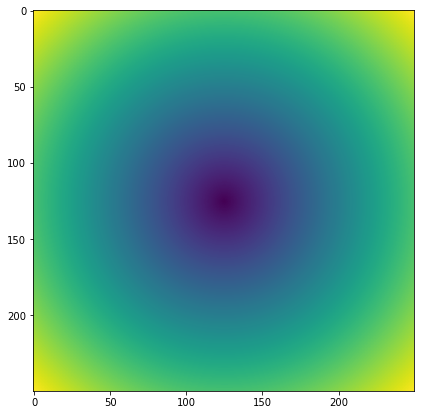

In [2]:
#creating an image where the brightness of each pixel is proportional to the distance from the centre

xx, yy = np.mgrid[:resolution, :resolution]
circle = ((xx - resolution/2) ** 2 + (yy - resolution/2) ** 2)*0.05*2/(resolution**2)

new_circ = np.sqrt(circle)
plt.figure(1, figsize = (7, 7))
plt.imshow(new_circ)

In [3]:
#Read the data from the diffraction files

graph_dir = 'D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\Diffraction_txt_files\\'
graph_dirs = []

for i in range(10):
    graph_dirs.append(graph_dir + '0.' + str(i) + '_Bi.txt')
    for j in range(1, 10):
        graph_dirs.append(graph_dir + '0.' + str(i) + str(j) + '_Bi.txt')
        
graph_dirs.append(graph_dir + '1.0_Bi.txt')
graph_dirs.append(graph_dir + '1.01_Bi.txt')
graph_dirs.append(graph_dir + '1.02_Bi.txt')

#radii and intensities are lists of lists, where each sublist of each corresponds to a radius intensity pair from the
#diffraction data
radii = []
intensities = []

for text_file in graph_dirs:
    radius = []
    intensity = []
    with open(text_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            angle, I = line.split('\t')
            angle_degrees = float(angle.strip('\n'))/2
            angle_radians = np.pi/180 * angle_degrees
            radius.append(scale*np.tan(angle_radians))
            intensity.append(float(I.strip('\n')))
        radii.append(radius)
        intensities.append(intensity)


In [4]:
#Using new_circ, we can create images of'donuts' (an array which consists of a ring of ones, and the rest zeros), and multiply
#these by intensities to create our diffraction rings. If the resolution is high, this will take a while.

diffraction_images = []

for i in range(len(graph_dirs)):
    
    base = np.zeros((resolution,resolution))
    j = 0
    radius = radii[i]
    intensity = intensities[i]
    prev_num = radius[0]
    for num in radius:
        donut = (new_circ <= num) & (new_circ > prev_num)
        donut = donut*intensity[j]
        base = base + donut
        prev_num = num
        j+=1
    
    #Rescaling so that the maximum is 8000 (without noise) so that it roughly matches the observed data
    diffraction_images.append(base*8000/90247000)

In [5]:
print(len(diffraction_images))
print(np.amax(diffraction_images[0]))

103
8000.0


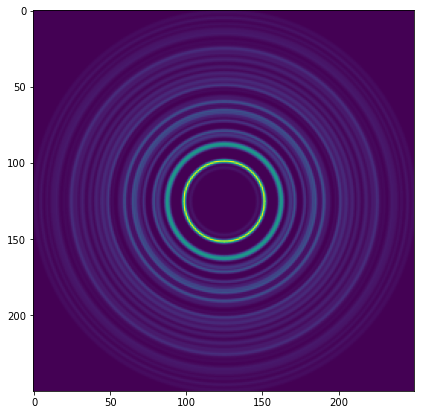

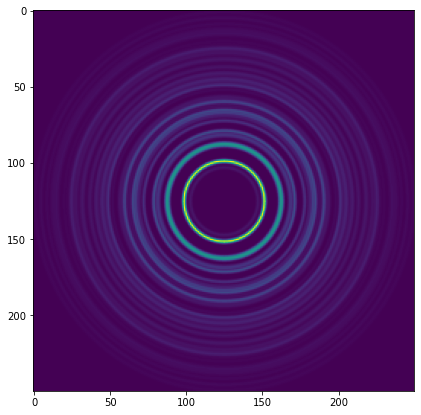

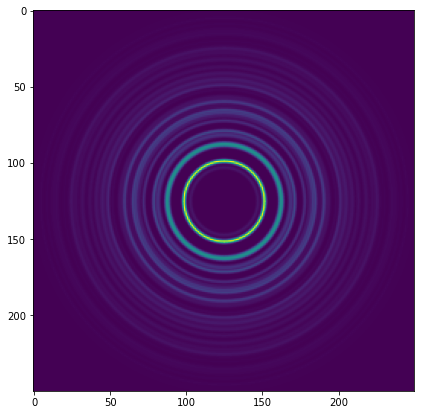

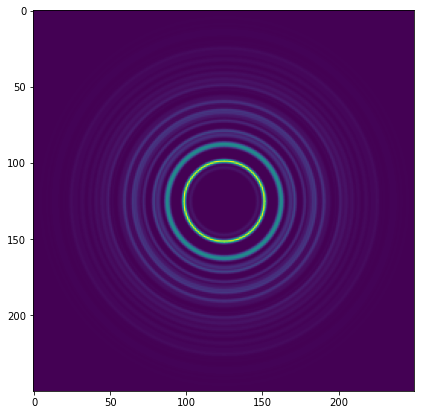

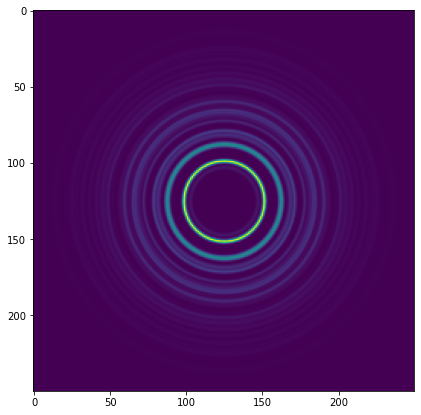

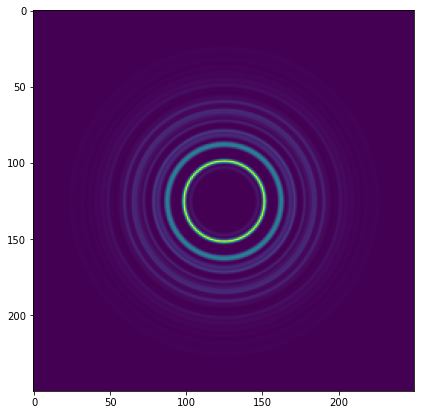

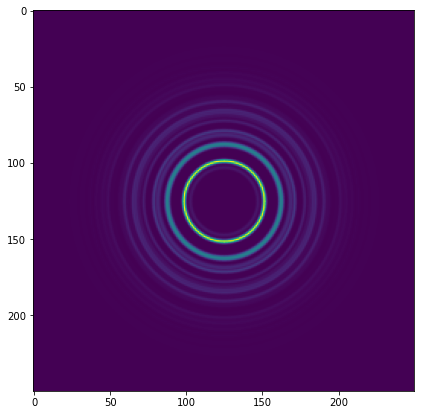

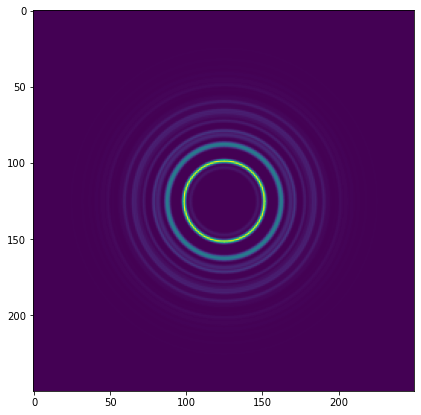

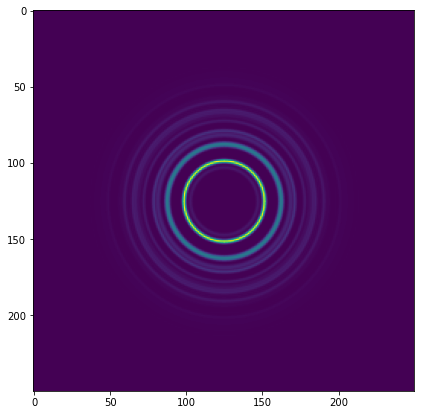

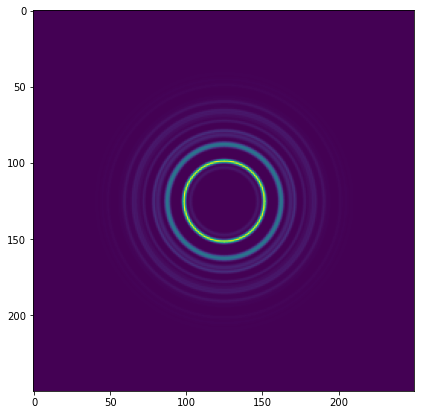

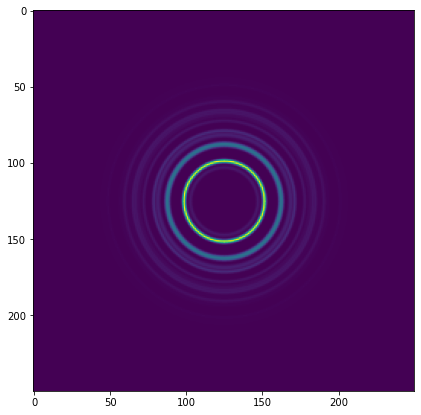

In [6]:
#The diffraction patterns have now been created. Here are some of the plots

%matplotlib inline

for i in range(11):
    plt.figure(i, figsize = (7, 7))
    plt.imshow(diffraction_images[i])

In [7]:
#This creates a very limited amount of data. Furthermore, it's too 'perfect' - there's no noise as you'd see in real diffraction
#images. I will try and artifically create more data by adding varying levels of noise to each of these diffraction patterns. We
#First define some functions

def create_multiplication_noise(image, noise_level = 0.2):
    """
    inputs: image - 2D grayscale numpy array
            noise_level - a float controlling how much noise to multiply Default is 0.2. Choosing a maximum of 0.35 is
                          reccommended
            
    returns: the original image + noise by multiplying the original image by a noisy image
    """
    multiplication_mask = 1 + (noise_level*np.random.randn(resolution, resolution))
    multnoise_diffraction_image = image*multiplication_mask
    
    return multnoise_diffraction_image

def create_addition_noise(image, noise_level = 0.015):
    """
    inputs: image - 2D grayscale numpy array
            noise_level - a float controlling how much noise to add. Default is 0.015. Choosing a maximum of 0.04 is
                          reccommended
            
    returns: the original image + noise by adding the original image to a noisy image
    """
    max_noise = 125*noise_level
    addition_mask = max_noise*np.random.randn(resolution, resolution)
    addnoise_diffraction_image = image + addition_mask
    
    return addnoise_diffraction_image

def create_noisy_images(image, mult_noise_levels, add_noise_levels):
    """
    inputs: image - 2D grayscale numpy array
            mult_noise_levels - a list of floats controlling how much noise to multiply.
            add_noise_levels - a list of floats controlling how much noise to add
            
    returns: A list of images with the added noise levels. the ith returned image will have noise levels mult_noise_levels[i]
    and add_noise_levels[i] added to it, for example. This function applies the multiplication noise first, then the addition 
    noise.
    
    PRECONDITION: len(mult_noise_levels) = len(add_noise_levels)
    """
    noisy_images = []
    
    for i in range(len(mult_noise_levels)):
        mult_noisy_image = create_multiplication_noise(image, mult_noise_levels[i])
        noisy_image = create_addition_noise(mult_noisy_image, add_noise_levels[i])
        noisy_images.append(noisy_image)
        
    return noisy_images

In [8]:
#We now add Gaussian Noise, to make it more accurate to the actual images
def gaussian_noise_2d(x, y, mean, stdev):
    return 4000 * np.exp((-(x - mean)**2 - (y - mean)**2)/(stdev)**2)

base = np.zeros((resolution, resolution))
for x in range(resolution):
    for y in range(resolution):
        base[x][y] = gaussian_noise_2d(x, y, resolution/2, 0.425*resolution)
        
gaussian_images = []

mult_noise_levels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
add_noise_levels = [0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2, 1, 1, 1, 1.02, 0.98, 1.05, 1.1, 1.1, 1.1, 1.1, 1.1]
        
gaussian_images.append(create_noisy_images(base, mult_noise_levels, add_noise_levels))

In [9]:
#This function will be used to create the bright spot in the middle of the images 
#of varying intensities (from 24000 - 31000, as this is what is observed in the real images 
#(with most lying betweenb 28000-31000))

def create_gaussian_base(max_noise, dist_from_cent, stdev):
    """
    Create a 2d gaussian image plot such that at a distance dist_from_cent away from the centre, the noise level is max_noise
    
    """
    base = np.zeros((resolution, resolution))
    constant = max_noise/4000 * np.exp(dist_from_cent**2/stdev**2)
    for x in range(resolution):
        for y in range(resolution):
            base[x][y] = constant * gaussian_noise_2d(x, y, resolution/2, stdev)
            
    return base
    

In [10]:
#We now create a ton of noisy images using these functions
noisy_images = []

for image in diffraction_images:
    classes = []
    for noise in gaussian_images:
        classes.extend(image + noise)
    noisy_images.append(classes)
        

print(len(noisy_images))
#for clss in noisy_images:
    #print(len(clss))


103


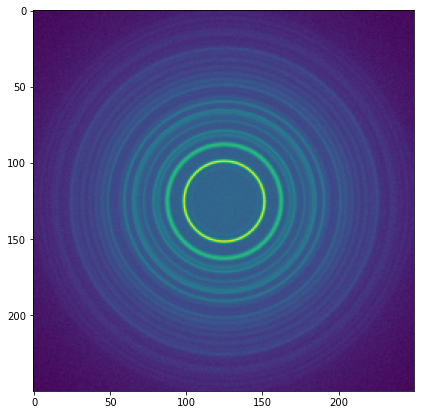

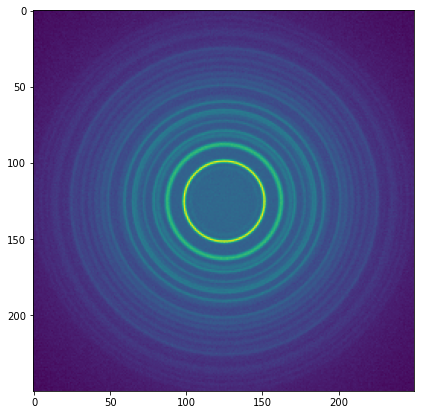

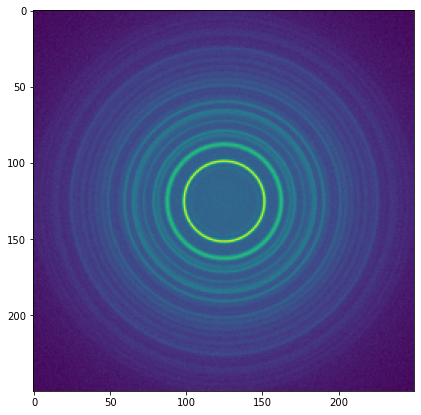

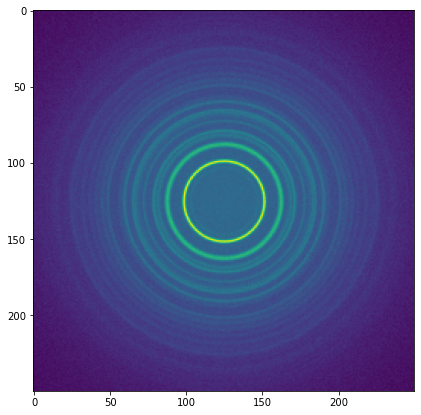

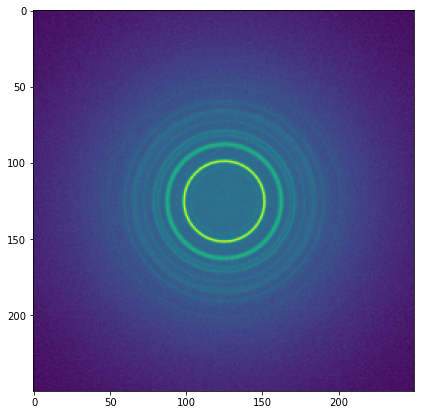

In [11]:
#noisy_images is a list of lists of images. noisy_images[i][j] picks out an image of the i'th class, with noise level j. 
#plotting some of these:

plt.figure(10, figsize = (7,7))
plt.imshow(noisy_images[0][3])

plt.figure(11, figsize = (7,7))
plt.imshow(noisy_images[0][10])

plt.figure(12, figsize = (7,7))
plt.imshow(noisy_images[0][18])

plt.figure(13, figsize = (7,7))
plt.imshow(noisy_images[1][17])

plt.figure(14, figsize = (7,7))
plt.imshow(noisy_images[5][17])

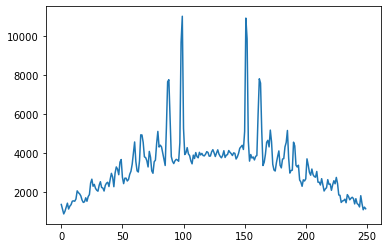

In [12]:
plt.plot(np.arange(resolution), noisy_images[0][5][resolution//2])

In [13]:
def realistic_image(image, bright_new_circ_clipped):
    """
    inputs: image - 2D grayscale numpy array. The synthetic diffraction image you want to make more realistic.

            
    returns: the original image + a beamstop + bright centre
    """
    #First create the Stopper
    yyneg, xx = np.mgrid[:resolution, :resolution]
    yneg = yyneg - resolution/2
    x = xx - resolution/2
    radial_lines = 3*x - yneg
    stopper = ((radial_lines < 6*scale/5*resolution/200) & (radial_lines >-6*scale/5*resolution/200))*(yyneg > resolution/2)
    stopper = (stopper == 0)
    
    #Now create the bright spot in the middle covered by the stopper
    bright_circle = ((x) ** 2 + (yneg) ** 2)*0.05*2/(resolution**2)

    #bright_new_circ = np.sqrt(circle)
    #bright_new_circ_clipped = np.clip(30000*50*((0.002*scale + 0.006) - bright_new_circ), 0, None)
    
    #bright_new_circ_clipped = create_gaussian_base(30000, 20, 20)
    
    stop_block = bright_circle > 0.00007*scale/5
    stopper = stopper*stop_block
    
    return ((image+bright_new_circ_clipped)*stopper,  bright_new_circ_clipped, bright_new_circ_clipped, stopper)
    

In [14]:
#Putting a stopper on all the noisy images:
noisy_images_real = []
bright_new_circ_clipped = create_gaussian_base(22000, 7, 8)

for list in noisy_images:
    lst=[]
    for img in list:
        lst.append(realistic_image(img, bright_new_circ_clipped)[0])
    noisy_images_real.append(lst)

In [15]:
noisy_images_real = []

bright_spots = []
bright_spots.append(create_gaussian_base(28000, 7, 8)) #30000
bright_spots.append(create_gaussian_base(27000, 7, 8)) #29000
bright_spots.append(create_gaussian_base(26000, 7, 8)) #28000
bright_spots.append(create_gaussian_base(25000, 7, 8)) #27000
bright_spots.append(create_gaussian_base(24000, 7, 8)) #26000
bright_spots.append(create_gaussian_base(23000, 7, 8)) #25000
bright_spots.append(create_gaussian_base(22000, 7, 8)) #24000

#4 of the images will have the first bright spot in bright_spots, 4 will have the second, 3 will have the third and 2 will have
#each of the reamining three. This is what 'indices' captures
indices = [0,0,0,0,1,1,1,1,2,2,2,3,3,3,4,4,5,5,6,6]

for listt in noisy_images:
    lst=[]
    for i in range(len(listt)):
        lst.append(realistic_image(listt[i], bright_spots[indices[i]])[0])
    noisy_images_real.append(lst)

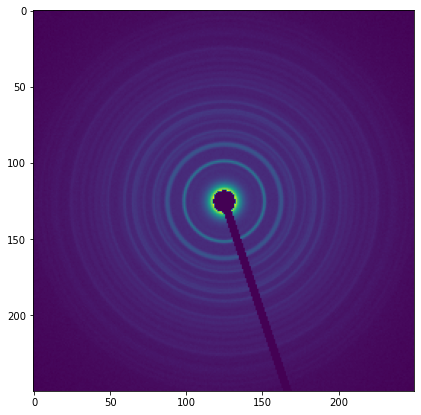

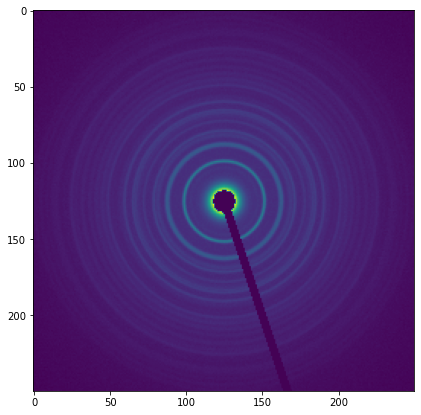

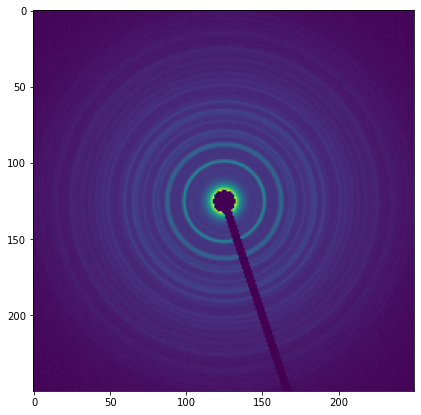

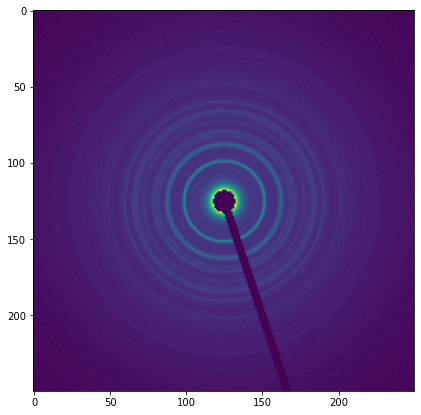

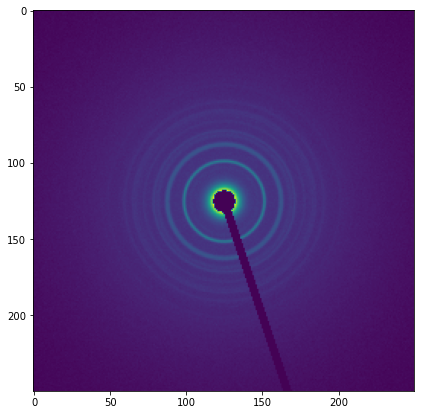

In [16]:
plt.figure(16, figsize = (7,7))
plt.imshow(noisy_images_real[0][3])

plt.figure(17, figsize = (7,7))
plt.imshow(noisy_images_real[0][10])

plt.figure(18, figsize = (7,7))
plt.imshow(noisy_images_real[0][18])

plt.figure(19, figsize = (7,7))
plt.imshow(noisy_images_real[1][17])

plt.figure(20, figsize = (7,7))
plt.imshow(noisy_images_real[5][17])

In [17]:
print(np.amax(noisy_images_real[0][5]))

29450.022775423015


In [18]:
#Defining a function to import and reshape/rescale the real images for comparison with the synthetic images

def preprocess_img(onimg, directory):
    testing_dir = 'D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Testing\\' + directory + '\\'
    on_file = testing_dir + onimg

    #The actual images aren't square like the synthetic images. This is why when I scale them down using load_img, I scale them
    #down to a rectangle which is similar to its original shape so that tensorflow doesn't automatically squish the images:
    onimg = load_img(on_file, color_mode = "grayscale", target_size = (resolution, int(1.148*resolution)), interpolation = 'nearest')
    
    #onimg is now a rectangle. So we crop it into a square while attempting to keep the rings roughly centralised. The exact
    #numbers for these steps were a mix of trial and error and some math.
    onimg = np.array(onimg.crop((int(0.1*resolution), 0, int(1.1*resolution), resolution)))
    onimg = onimg.astype(np.int16)
    
    return onimg

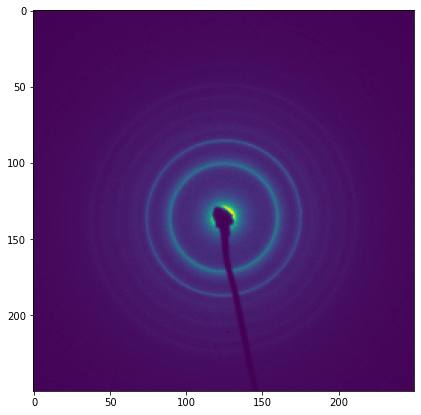

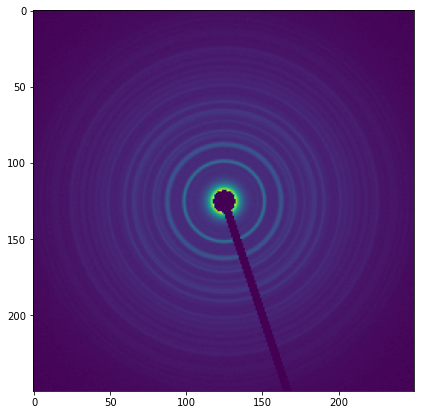

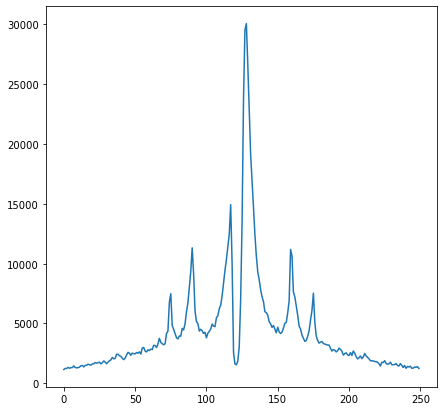

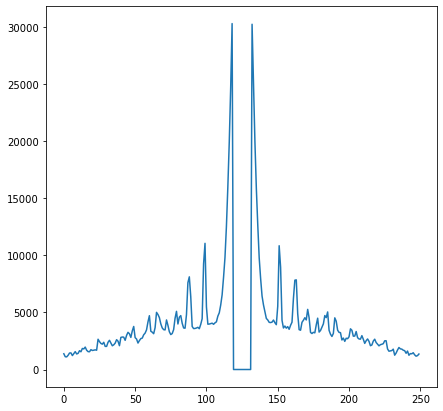

In [19]:
#Let's now compare a synthetic uiso = 0 image to a real 'off' image. I'll do this by showing the images themselves, along with
#a plot of the cross section along a horizontal line crossing the centre of the images.

offimg = preprocess_img('scan3_000063_GL-1_010500_fs_Off_   NaN_md_.tiff', '')

plt.figure(21, figsize = (7, 7))
plt.imshow(offimg)

plt.figure(22, figsize = (7, 7))
plt.imshow(noisy_images_real[0][0])

plt.figure(23, figsize = (7, 7))
plt.plot(np.arange(resolution), offimg[130])

plt.figure(24, figsize = (7, 7))
plt.plot(np.arange(resolution), noisy_images_real[0][0][127])



In [20]:
#This block is optional and sets the maximum of every image to 12000. Ideally I'd set the maximum to exactly 1, so that the 
#images are fully normalized, but when I save the images as a png, the pixel values must be integers, so I can't do this. 
#Instead I 'normalize' to 12000, then when I import the images for training in the neural network, I divide by 12000 again.

final_images = []

for clss in noisy_images_real:
    final_class = []
    for img in clss:
        final_class.append(img * 12000/np.amax(img))
    final_images.append(final_class)
        


In [ ]:
#SAVING NORMAL IMAGES

directory = 'D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\regression_neural_net_normalised\\moreimages\\'

for class_index in range(len(final_images)):
    for image_index in range(len(final_images[class_index])):
        image = final_images[class_index][image_index].astype(int)
        img = Image.fromarray(image)
        img.save(directory + 'img' + str(image_index + 20*class_index) + '.png')
        

In [10]:
#If I ever want to delete the files in the directory

import os

for i in range(11):
    filelist = [ f for f in os.listdir('D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Training\\' + str(i))]
    for f in filelist:
        os.remove(os.path.join('D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Training\\' +str(i), f))
        
for i in range(11):
    filelist = [ f for f in os.listdir('D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Validation\\' + str(i))]
    for f in filelist:
        os.remove(os.path.join('D:\\Uni\\Year 3 Summer\\NSERC\\First_task_bismuth\\neural_net\\Validation\\' +str(i), f))